# Прогнозирование коэффициента восстановления золота

**Описание исследования**  

Необходимо подготовить прототип модели машинного обучения для компании «Цифра», которая разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Цель исследования**
- Создать модель, способную предсказать коэффициент восстановления золота из золотосодержащей руды

**Ход исследования**
- Обзор и предобработка данных
- Построение модели
- Проверка на тестовой выборке
- Общий вывод

**Описание процесса восстановления золота**


Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.  

<p align="center">
    <img src="https://i.ibb.co/0VGwfVb/image.png"> 

1. Флотация  
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка   
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

## Импорт библиотек и загрузка данных

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import six


from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from scipy.stats import uniform, randint
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from numpy.random import RandomState
from scipy import stats as st

In [98]:
try:
    df_full = pd.read_csv(
        r"C:\workspace\yandex_cources\full_history\sprint_8_second_checkpoint\data\gold_recovery_full_new.csv"
    )
except:
    df_full = pd.read_csv(r"/datasets/gold_recovery_full_new.csv")

In [99]:
try:
    df_train = pd.read_csv(
        r"C:\workspace\yandex_cources\full_history\sprint_8_second_checkpoint\data\gold_recovery_train_new.csv"
    )
except:
    df_train = pd.read_csv(r"/datasets/gold_recovery_train_new.csv")

In [100]:
try:
    df_test = pd.read_csv(
        r"C:\workspace\yandex_cources\full_history\sprint_8_second_checkpoint\data\gold_recovery_test_new.csv"
    )
except:
    df_test = pd.read_csv(r"/datasets/gold_recovery_test_new.csv")

## **Обзор и предобработка данных**

In [101]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [102]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [103]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Признаки, отсутствующие в тестововом датасете: 

In [104]:
df_full.drop(columns=df_test.columns).columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

**Вывод:**  
В тестовом датасете отсутствуют типы output и calculation.  
Стоит обратить внимание на пропуски в данных. 

In [105]:
# колонок много; снимем ограничения, чтобы видеть информацию полностью
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)

### Названия столбцов

Система с точками удобна для понимания структуры названий столбцов, но в дальнейшем будет мешать, поэтому приведем названия к snake_case. 

In [106]:
df_list = [df_full, df_train, df_test]
for df in df_list:
    for i, column in enumerate(df.columns):
        df.rename(
            columns={
                df.columns[i]: "_".join(re.findall("[a-z0-9_]*[^.]", df.columns[i]))
            },
            inplace=True,
        )

In [107]:
df_train.columns[25]

'primary_cleaner_state_floatbank8_b_level'

Пока исходный датасет не обработан, создадим набор целевых признаков для тестовой выборки.

In [108]:
y_test = df_full[df_full["date"].isin(df_test["date"])][
    ["rougher_output_recovery", "final_output_recovery"]
]

### Расчет эффективности обогащения

In [109]:
T = df_train["rougher_output_tail_au"]
F = df_train["rougher_input_feed_au"]
C = df_train["rougher_output_concentrate_au"]

In [110]:
recovery_calculated = (C * (F - T)) / (F * (C - T)) * 100

In [111]:
mean_absolute_error(recovery_calculated, df_train["rougher_output_recovery"])

9.73512347450521e-15

In [112]:
recov_fin = []
for column in df_full.columns:
    if "output" in column and "isna" not in column:
        recov_fin.append(column)
df_train[recov_fin].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   final_output_concentrate_ag             14148 non-null  float64
 1   final_output_concentrate_pb             14148 non-null  float64
 2   final_output_concentrate_sol            13938 non-null  float64
 3   final_output_concentrate_au             14149 non-null  float64
 4   final_output_recovery                   14149 non-null  float64
 5   final_output_tail_ag                    14149 non-null  float64
 6   final_output_tail_pb                    14049 non-null  float64
 7   final_output_tail_sol                   14144 non-null  float64
 8   final_output_tail_au                    14149 non-null  float64
 9   primary_cleaner_output_concentrate_ag   14149 non-null  float64
 10  primary_cleaner_output_concentrate_pb   14063 non-null  fl

**Вывод:** Значение MAE имеет высокую отрицательную степень, значит эффективность обогащения была рассчитана правильно. Небольшое расхождение скорее всего связано с тем, что в датасете числа имеют конечный знак после запятой, в то время как рассчитанные в реальном времени могут иметь куда большее число знаков. 

### Изменение концентрации металлов в процессе восстановления

Рассмотрим как меняются концентрации металлов:

Text(0, 0.5, 'Частота')

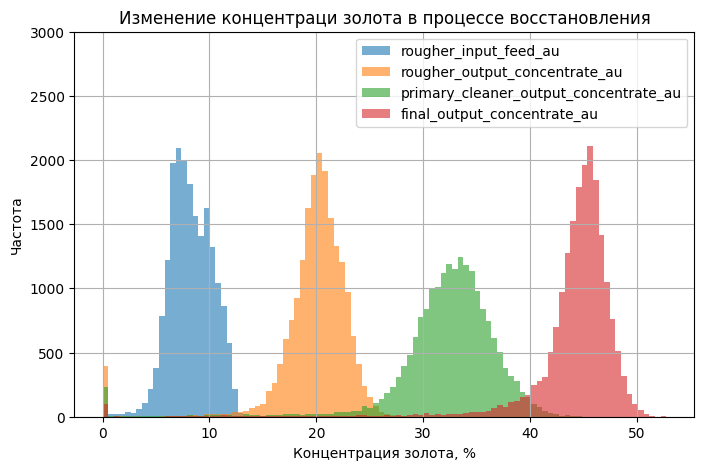

In [113]:
df_full[
    [
        "rougher_input_feed_au",
        "rougher_output_concentrate_au",
        "primary_cleaner_output_concentrate_au",
        "final_output_concentrate_au",
    ]
].plot(kind="hist", bins=100, figsize=(8, 5), alpha=0.6, ylim=(0, 3000), grid=True)
plt.title("Изменение концентраци золота в процессе восстановления")
plt.xlabel("Концентрация золота, %")
plt.ylabel("Частота")

Text(0, 0.5, 'Частота')

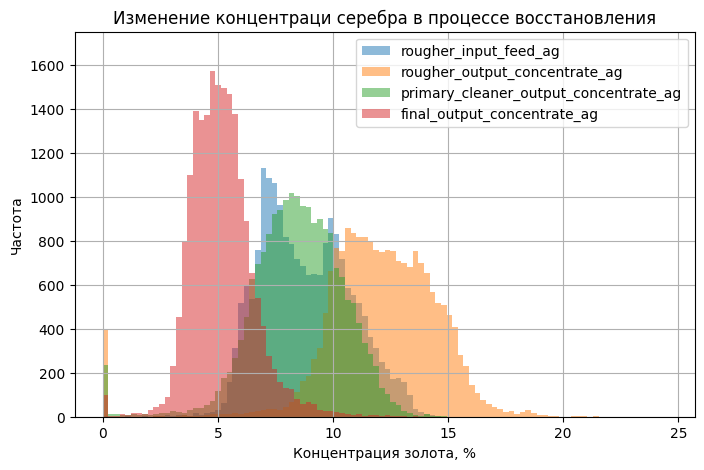

In [114]:
df_full[
    [
        "rougher_input_feed_ag",
        "rougher_output_concentrate_ag",
        "primary_cleaner_output_concentrate_ag",
        "final_output_concentrate_ag",
    ]
].plot(kind="hist", bins=100, figsize=(8, 5), alpha=0.5, ylim=(0, 1750), grid=True)
plt.title("Изменение концентраци серебра в процессе восстановления")
plt.xlabel("Концентрация золота, %")
plt.ylabel("Частота")

Text(0, 0.5, 'Частота')

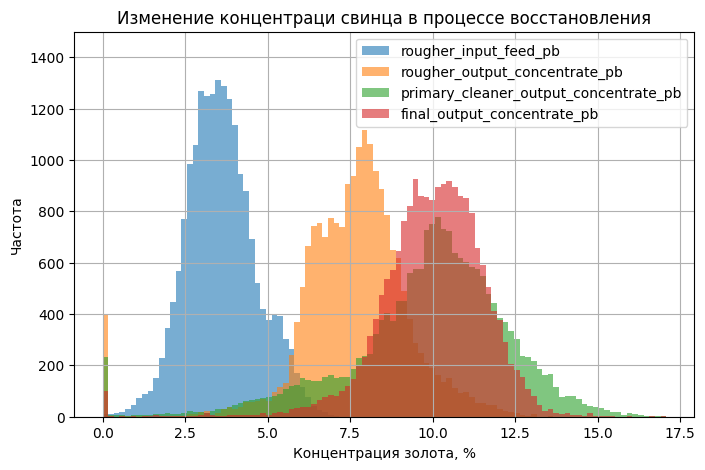

In [115]:
df_full[
    [
        "rougher_input_feed_pb",
        "rougher_output_concentrate_pb",
        "primary_cleaner_output_concentrate_pb",
        "final_output_concentrate_pb",
    ]
].plot(kind="hist", bins=100, figsize=(8, 5), alpha=0.6, ylim=(0, 1500), grid=True)
plt.title("Изменение концентраци свинца в процессе восстановления")
plt.xlabel("Концентрация золота, %")
plt.ylabel("Частота")

**Вывод:** В процессе очистки процент содержания металлов в концентрате меняется следующим образом:
- Содержание золота постепенно поднимается с ~8% до ~20% после флотации, ~35% после первого этапа очистки и ~45% после второго;
- Содержание серебра поднимается с 6-11% до 10-16% после флотации, а затем падает обратно до 6-11% после первого этапа очистки и стабилизируется около 3-4% после второго;
- Содержание свинца поднимается с 3-4% до 7-8% после флотации, затем еще подрастает после первого этапа очистки и стабилизируется вокруг 9-11% после второго. 

На графиках присутствуют пики около 0, которые можно интерпретировать как пропуски в данных.

### Распределение размеров гранул сырья

Построим графики плотности для сравнения распределений в датафреймах.

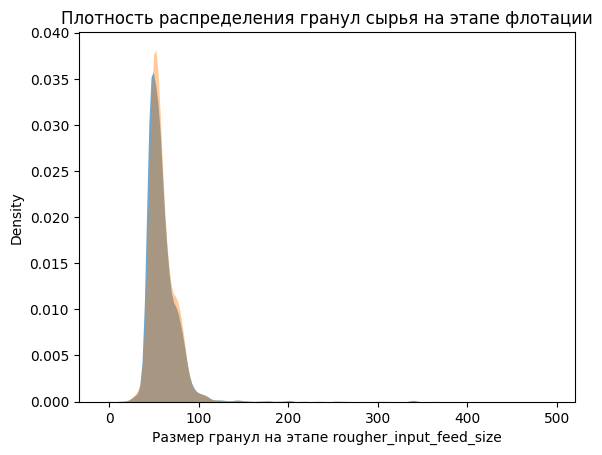

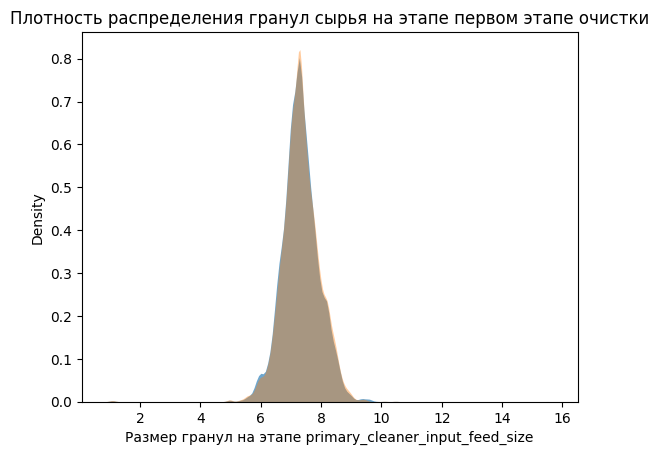

In [116]:
stage = ["флотации", "первом этапе очистки"]
for i, column in enumerate(
    ["rougher_input_feed_size", "primary_cleaner_input_feed_size"]
):
    sns.kdeplot(df_full[column], alpha=0.65, fill=True, linewidth=0)
    sns.kdeplot(df_train[column], alpha=0.4, fill=True, linewidth=0)
    plt.xlabel(f"Размер гранул на этапе {column}")
    plt.title(f"Плотность распределения гранул сырья на этапе {stage[i]}")
    plt.show()

**Вывод:** Распределения совпадают, значит обучение модели по данным признакам будет происходить корректно. 

### Расчет суммарных концентраций

Посчитаем суммарную концентрацию веществ на каждом из этапов: в сырье, в черновом и финальном концентратах 

Text(0, 0.5, 'Частота')

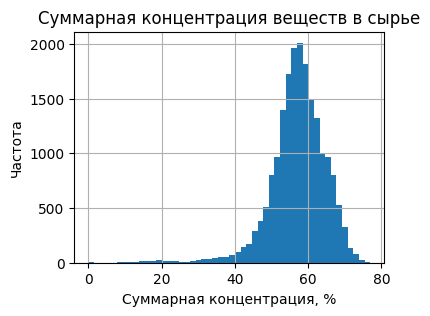

In [117]:
rougher_input_concentrate_sum = df_full[
    [
        "rougher_input_feed_ag",
        "rougher_input_feed_au",
        "rougher_input_feed_pb",
        "rougher_input_feed_sol",
    ]
].sum(axis=1)
rougher_input_concentrate_sum.hist(bins=50, figsize=(4, 3))
plt.title("Суммарная концентрация веществ в сырье")
plt.xlabel("Суммарная концентрация, %")
plt.ylabel("Частота")

Text(0, 0.5, 'Частота')

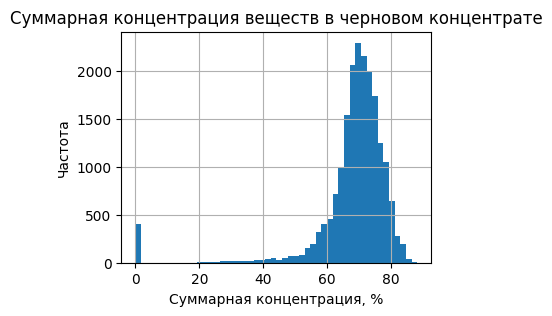

In [118]:
rougher_output_concentrate_sum = df_full[
    [
        "rougher_output_concentrate_ag",
        "rougher_output_concentrate_au",
        "rougher_output_concentrate_pb",
        "rougher_output_concentrate_sol",
    ]
].sum(axis=1)
rougher_output_concentrate_sum.hist(bins=50, figsize=(4, 3))
plt.title("Суммарная концентрация веществ в черновом концентрате")
plt.xlabel("Суммарная концентрация, %")
plt.ylabel("Частота")

Text(0, 0.5, 'Частота')

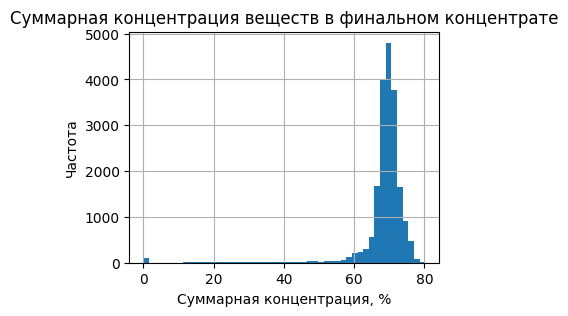

In [119]:
final_output_concentrate_sum = df_full[
    [
        "final_output_concentrate_ag",
        "final_output_concentrate_au",
        "final_output_concentrate_pb",
        "final_output_concentrate_sol",
    ]
].sum(axis=1)
final_output_concentrate_sum.hist(bins=50, figsize=(4, 3))
plt.title("Суммарная концентрация веществ в финальном концентрате")
plt.xlabel("Суммарная концентрация, %")
plt.ylabel("Частота")

**Вывод:** Суммарная концентрация возрастает после флотации и стабилизируется около 70% после двух этапов очистки. На графиках выходных концентраций на этапе флотации и финальных концентраций присутствуют пики около 0, которыу можно интерпретировать как набор пропусков.  

### Обработка пропусков

Известно, что данные индексируются датой/временем и соседние параметры "похожи", благодаря чему пропуски можно было бы заполнить средним между ближайшими соседями.

Определим, к какому числу строк без пропусков мы стремимся.

In [120]:
max(df_train.count())

14149

Посмотрим, сколько всего пропусков присутствует.

In [121]:
df_train.isna().sum().sum()

4100

In [122]:
bad_boys_team = (
    df_train.isna().sum()[df_train.isna().sum() != 0].sort_values(ascending=False)
)
bad_boys_names = pd.Series(bad_boys_team.index).tolist()
display(bad_boys_team, len(bad_boys_team))

secondary_cleaner_output_tail_sol                     1605
rougher_state_floatbank10_e_air                        436
rougher_input_floatbank11_xanthate                     428
primary_cleaner_output_concentrate_sol                 286
secondary_cleaner_state_floatbank2_a_air               217
final_output_concentrate_sol                           211
rougher_input_feed_size                                144
final_output_tail_pb                                   100
rougher_input_feed_pb                                  100
primary_cleaner_input_xanthate                         100
primary_cleaner_output_concentrate_pb                   86
rougher_input_feed_sol                                  78
primary_cleaner_output_tail_sol                         46
rougher_input_floatbank11_sulfate                       36
primary_cleaner_input_depressant                        32
rougher_input_floatbank10_sulfate                       29
rougher_output_concentrate_sol                          

62

Известно, что соседние по времени параметры похожи. Проверим, насколько это соответствует истине и можно ли ближайшими предыдущими соседями заполнить пропуски. Но перед этим изменим тип столбца date на Datetime64.

In [123]:
df_train["date"] = pd.to_datetime(df_train["date"], format="%Y-%m-%d %H:%M:%S")

In [124]:
df_train = df_train.sort_values(by="date")

Определим индексы строк, где разница с последующей или предыдущей датой составляет более 1 часа. 

In [125]:
indexes = df_train[df_train["date"].diff() / np.timedelta64(1, "h") > 1]["date"].index
indexes = indexes.append(indexes - 1)
len(indexes)

656

Теперь посчитаем разницу между фактическим и предыдущим значением, исследуем при помощи метода .describe().

In [126]:
df_train = df_train.sort_index()
(
    df_train.replace(0, np.nan).drop(columns="date")
    / df_train.shift(1).replace(0, np.nan).drop(columns="date")
).describe().T.drop(columns="count")

,mean,std,min,25%,50%,75%,max
final_output_concentrate_ag,1.069630e+00,6.306168e+00,1.681717e-02,0.955739,0.998548,1.042934,7.477529e+02
final_output_concentrate_pb,1.085184e+00,8.539576e+00,7.200904e-03,0.978511,0.999756,1.021603,1.012829e+03
final_output_concentrate_sol,1.072298e+00,6.539618e+00,4.927757e-03,0.976309,1.000062,1.024438,7.679531e+02
final_output_concentrate_au,1.240736e+00,2.680976e+01,1.049578e-03,0.987300,1.000570,1.013707,3.179634e+03
final_output_recovery,1.056810e+00,3.733886e+00,1.957415e-03,0.974323,1.000000,1.026833,4.024065e+02
final_output_tail_ag,1.072221e+00,3.626008e+00,3.288325e-03,0.980182,1.000329,1.020557,3.981129e+02
final_output_tail_pb,1.077305e+00,3.980902e+00,3.173327e-03,0.958539,0.999889,1.043833,4.482781e+02
final_output_tail_sol,1.041791e+00,1.034252e+00,9.394880e-03,0.973081,1.001129,1.030924,6.808512e+01
final_output_tail_au,1.073110e+00,3.501650e+00,3.474860e-03,0.954618,1.000140,1.045613,3.839970e+02
primary_cleaner_input_sulfate,1.126446e+00,7.463737e+00,9.041031e-04,0.969067,1.000372,1.036488,6.022080e+02


Медиана отношения между значением и предыдущим ему равна 1 или близка к ней у всех колонок, значит, заполнение пропусков данным методом оправдано. 

Заполним пропуски при помощи ближайшего предыдущего соседа.

In [127]:
# df_train = df_train.fillna(method='pad', limit=5)

In [128]:
# result = df_train[bad_boys_names].isna().sum() - bad_boys_team
# result, result.sum()

Получилось убрать 1895 из 4100 пропусков. (если бы ffill использовался)

In [129]:
# df_train = df_train.dropna()
# len(df_train)

**Вывод:** В тренировочном датасете были заполнены пропуски, для которых это было возможно сделать. Оставшиеся строки с пропусками были удалены. 

**UPD**: заполнение пропусков заменено на KNNImputer

## Построение модели

### Отбор признаков для обучения

Будет пыполнено два варианта построения модели: совместный, использующий один набор данных для определения обоих целевых признаков, и раздельный, где для определения параметров чернового концентрата будут использованы лишь те признаки, что относятся непосредственно к процессу флотации. 

In [130]:
X = df_train[df_test.columns].drop(columns="date")

In [131]:
y = df_train[["rougher_output_recovery", "final_output_recovery"]]

In [132]:
multi_roughed_data_list = [X, y["rougher_output_recovery"]]
multi_final_data_list = [X, y["final_output_recovery"]]
multi_data_list = [multi_roughed_data_list, multi_final_data_list]

In [133]:
rougher_columns = X.filter(regex="^rougher", axis=1).columns

In [134]:
# список признаков для раздельной модели
roughed_data_list = [X.loc[:, rougher_columns], y["rougher_output_recovery"]]
final_data_list = [X, y["final_output_recovery"]]
sep_data_list = [roughed_data_list, final_data_list]

### Обучение моделей

Составим функции
- Расчета показателя sMAPE
- Скоринга моделей
- Вывода результатов модели

In [135]:
def smape_score(targets, predictions):
    return (
        abs(targets - predictions) / ((abs(targets) + abs(predictions)) / 2)
    ).mean() * 100

In [136]:
def smape_print(smape):
    print("=" * 79)
    print(f"\nsMAPE = {abs(.25 * smape[0] + 0.75 * smape[1]):.3f} %\n")
    print("=" * 79)

In [137]:
reg_pipe = Pipeline([("knn", KNNImputer()), ("std", StandardScaler()), ("reg", SVR())])

In [138]:
params = {
    "knn__n_neighbors": np.arange(3, 9, 2),
    "reg__epsilon": np.arange(0.5, 1, 0.1),
    "reg__C": np.arange(0.1, 1, 0.1),
}

### Совместная модель

In [139]:
%%time

multi_model = []
multi_smape = []
for data_list in multi_data_list:
    rs = RandomizedSearchCV(
        reg_pipe,
        params,
        n_jobs=4,
        cv=5,
        error_score='raise',
        scoring=make_scorer(smape_score, greater_is_better=False),
        random_state=868
    )
    rs.fit(data_list[0], data_list[1])
    multi_smape.append(rs.best_score_)
    multi_model.append(rs.best_estimator_)
smape_print(multi_smape)


sMAPE = 9.988 %

CPU times: total: 26.4 s
Wall time: 6min 42s


### Раздельная модель

In [140]:
%%time

sep_model = []
sep_smape = []
for data_list in sep_data_list:
    rs = RandomizedSearchCV(
        reg_pipe,
        params,
        n_jobs=4,
        cv=5,
        scoring=make_scorer(smape_score, greater_is_better=False),
        error_score='raise',
        random_state=868
    )
    rs.fit(data_list[0], data_list[1])
    sep_smape.append(rs.best_score_)
    sep_model.append(rs.best_estimator_)
smape_print(sep_smape)


sMAPE = 10.126 %

CPU times: total: 26 s
Wall time: 6min 6s


**Вывод:** Определение параметров чернового концентрата только по тем признакам, что относятся к процессу флотации, не дает улучший в точности предсказания. Более удачной будем считать совместную модель. 

In [141]:
corrs = (
    df_full.drop(columns=["date"])
    .corr(numeric_only=True)
    .where(
        np.triu(np.ones(df_full.drop(columns=["date"]).corr().shape), 1).astype(bool)
    )
    .stack()
    .reset_index()
    .sort_values(by=0, ascending=False)
)
corrs.columns = ["Clmn_1", "Clmn_2", "Value"]

In [142]:
corrs.head(20)

,Clmn_1,Clmn_2,Value
3191,rougher_state_floatbank10_b_level,rougher_state_floatbank10_c_level,0.987836
3356,rougher_state_floatbank10_e_level,rougher_state_floatbank10_f_level,0.980917
3250,rougher_state_floatbank10_c_level,rougher_state_floatbank10_d_level,0.980911
3193,rougher_state_floatbank10_b_level,rougher_state_floatbank10_d_level,0.971205
2115,rougher_calculation_floatbank10_sulfate_to_au_...,rougher_calculation_floatbank11_sulfate_to_au_...,0.965838
3252,rougher_state_floatbank10_c_level,rougher_state_floatbank10_e_level,0.962115
1576,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_b_air,0.953129
3254,rougher_state_floatbank10_c_level,rougher_state_floatbank10_f_level,0.952530
3195,rougher_state_floatbank10_b_level,rougher_state_floatbank10_e_level,0.951971
3305,rougher_state_floatbank10_d_level,rougher_state_floatbank10_e_level,0.949670


## Проверка на тестовой выборке

In [143]:
X_test = df_test[X.columns]
y_test_rougher = y_test["rougher_output_recovery"]
y_test_final = y_test["final_output_recovery"]

In [144]:
test_lists = [[X_test, y_test_rougher], [X_test, y_test_final]]

In [145]:
test_smape_score = []
for i, data_list in enumerate(test_lists):
    test_smape_score.append(
        smape_score(multi_model[i].predict(data_list[0]), data_list[1])
    )
smape_print(test_smape_score)


sMAPE = 8.706 %



**Вывод:** Показатели модели на тестовой выборке даже лучше, чем кросс-валидационные значения.

## Проверка модели на вменяемость

In [146]:
md = DummyRegressor()

In [147]:
dummy_list = [
    [X, X_test, y.iloc[:, 0], y_test.iloc[:, 0]],
    [X, X_test, y.iloc[:, 1], y_test.iloc[:, 1]],
]

In [148]:
smape_dummy_score = []
for data in dummy_list:
    md.fit(data[0], data[2])
    smape_dummy_score.append(smape_score(md.predict(data[1]), data[3]))
smape_print(smape_dummy_score)
print(
    f"\nУлучшение результата основной модели по сравнению с dummy-моделью составляет {pd.Series(smape_dummy_score).mean() - (0.25 * test_smape_score[0] + 0.75 * test_smape_score[1]):.3f} %"
)


sMAPE = 10.290 %


Улучшение результата основной модели по сравнению с dummy-моделью составляет 1.614 %


**Вывод:** Модель прошла проверку на вменяемость

## Общий вывод

В ходе выполнения исследования был изучен набор данных, содержащих параметры добычи и очистки золотосодержащей руды.  
**Выполнены следующие действия:**  
- Обзор и предобработка данных, в ходе которых выполнены:
    1. Проверка расчета эффективности восстановления после этапа флотации, показавшая, что расчет выполнен верно;
    2. Исследование изменений концентрации металлов на различных этапах очистки, показавший, что в процессе очистки процент содержания металлов в концентрате меняется следующим образом: 

        Содержание золота постепенно поднимается с ~8% до ~20% после флотации, ~35% после первого этапа очистки и ~45% после второго;

        Содержание серебра поднимается с 6-11% до 10-16% после флотации, а затем падает обратно до 6-11% после первого этапа очистки и стабилизируется около 3-4% после второго; 

        Содержание свинца поднимается с 3-4% до 7-8% после флотации, затем еще подрастает после первого этапа очистки и стабилизируется вокруг 9-11% после второго; 

        На графиках присутствуют пики около 0, которые можно интерпретировать как пропуски в данных.

    3. Исследование распределения гранул сырья в обучающей и тестовой выборках, показавшее, что распределения совпадают, значит обучение модели по данным признакам происходит корректно.  

    4. Исследование суммарной концентрации всех веществ, показавшее, что суммарная концентрация возрастает после флотации и стабилизируется около 70% после двух этапов очистки.  

        На графиках выходных концентраций на этапе флотации и финальных концентраций присутствуют пики около 0, которые интерпретируются как пропуски.

    5. Обработка явных и неявных пропусков в полном датасете посредством заполнения средним между ближайшими соседями, обработка оставшихся пропусков

- Построение совместной и раздельных моделей машинного обучения, прогнозирующих коэффициент восстановления золота из золотосодержащей руды, включающее повторное построение набора обучающих признаков на основе предобработанного полного датасета и подбор гипер-параметров при помощи случайного поиска;
- Проверка лучшей модели на тестовой выборке и проверка на вменяемость, включающая повторное построение набора тестовых признаков аналогично предыдущему пункту.

**Получены следующие результаты:**  

Совместная модель определена как более точная. Ее показатели на тестовой выборке:  

In [149]:
smape_print(test_smape_score)


sMAPE = 8.706 %



В сравнении с простейшей моделью, использованной в проверке на вменяемость, присуствутвует улучшение метрики sMAPE на 1.614 %. Таким образом, построенная модель прошла проверку на вменяемость. 